<a href="https://colab.research.google.com/github/akshaypt7/energy_predictor/blob/main/Energy_predictor_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from IPython.display import display, HTML

from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

from sklearn.inspection import permutation_importance, plot_partial_dependence, permutation_importance

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.preprocessing import OrdinalEncoder
from sklearn.datasets import load_boston

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns

In [ ]:
!pip install PrettyTable
from prettytable import PrettyTable

## Loading Data

In [ ]:
!pip install pickle5

import pickle5 as pickle
with open('/content/drive/MyDrive/Energy_predictor/train.pkl', "rb") as fh:
  df_train = pickle.load(fh)

     |████████████████████████████████| 133kB 8.5MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219249 sha256=303d3619c55d99defebfb0504e4ff0cfd2b9a3804f1447e50e462d6e0058da8f
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [ ]:
df_train.shape


(20216100, 4)

In [ ]:
df_building = pd.read_csv('/content/drive/MyDrive/Energy_predictor/building_metadata.csv')


In [ ]:
df_building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [ ]:

df_test = pd.read_csv('/content/drive/MyDrive/Energy_predictor/test.csv')

In [ ]:
df_weather_train = pd.read_csv('/content/drive/MyDrive/Energy_predictor/weather_train.csv')

In [ ]:
df_weather_test = pd.read_csv('/content/drive/MyDrive/Energy_predictor/weather_train.csv')

In [ ]:
def pretty_print(df
                 ):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

In [ ]:
def tbl_report(tbl, cols=None, card=10):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='HC' # high cardinality
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return df[cols]
    return df


In [ ]:
pretty_print(tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts']))

Table Shape (20216100, 4)


,dtype,nulls,num_uniques,value_counts
building_id,int16,0,1449,HC
meter,int8,0,4,0:120609101:41824402:27087133:1264037
timestamp,object,0,8784,HC
meter_reading,float32,0,1688175,HC


In [ ]:
pretty_print(tbl_report(df_weather_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts']))

Table Shape (139773, 9)


,dtype,nulls,num_uniques,value_counts
site_id,int64,0,16,HC
timestamp,object,0,8784,HC
air_temperature,float64,55,620,HC
cloud_coverage,float64,69173,11,HC
dew_temperature,float64,113,523,HC
precip_depth_1_hr,float64,50289,129,HC
sea_level_pressure,float64,10618,710,HC
wind_direction,float64,6268,44,HC
wind_speed,float64,304,59,HC


In [ ]:
table_report = tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])

plt.figure(figsize=(10,10))
plt.bar(table_report.index, table_report['num_uniques'])
plt.xticks(rotation=90, fontsize=10)
plt.show()

## Memory Reduction 

Self Note :The below code is reducing the memory size by checking the objects types and if for example one is in 'int64', it will convert that into the smallest format that would be 'int32'.
Learn more about = https://doc.embedded-wizard.de/int-type?v=10.00

In [ ]:
def memory_reduction(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2   # current memory usage of the dataframe passed
    for column in df.columns:
        column_type = df[column].dtypes  # data type of each cloumn
        if column_type in numerics:
            c_min = df[column].min()  #minimum value in column
            c_max = df[column].max()#maximum value in column
            if str(column_type)[:3] == 'int': # if the column is int object we try to change that into int8 or int16
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # We are checking if the max and min values in this column can be represented by int8 (if it comes in the range of values of int8, we change into int8)
                    df[column] = df[column].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[column] = df[column].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('size of the memory is reduced to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [ ]:

df_train = memory_reduction(df_train)
df_test = memory_reduction(df_test)
df_weather_train = memory_reduction(df_weather_train)

df_weather_test = memory_reduction(df_weather_test)
df_building = memory_reduction(df_building)

size of the memory is reduced to 289.19 Mb (0.0% reduction)
size of the memory is reduced to 63.67 Mb (53.1% reduction)
size of the memory is reduced to  3.07 Mb (68.1% reduction)
size of the memory is reduced to  3.07 Mb (68.1% reduction)
size of the memory is reduced to  0.03 Mb (60.3% reduction)


## EDA

In [ ]:
df_train.head()

In [ ]:
df_meter = df_train.groupby('meter')['building_id'].nunique()
for i in range(4):
  print('Number of Unique Businesses per meter type', i, '= ', df_meter[i] )

In [ ]:
print('Total Unique business ', df_train['building_id'].nunique())

#### Ploting the meter reading of a single business for an entire year( of a specific meter)

In [ ]:

def whole_year_reading(building_id, meter):
  row = df_train.query(f'building_id=={building_id} and meter =={meter} ') # This will give us all the rows where the columns values satisfies the condition
  row['day'] = pd.to_datetime(row['timestamp']).dt.dayofyear # adding day of year to the row above using timestamp
  sum_of_meter_day_readings = row.groupby(['day'])['meter_reading'].sum()
  title = 'meter reading of a building with meter ' + str(meter)
  sum_of_meter_day_readings.astype('float')
  plt.figure(figsize=(16,8))
  plt.title(title)
  plt.xlabel('timestamp in days')
  plt.ylabel('meter readings')
  plt.plot(sum_of_meter_day_readings)
  return row

  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


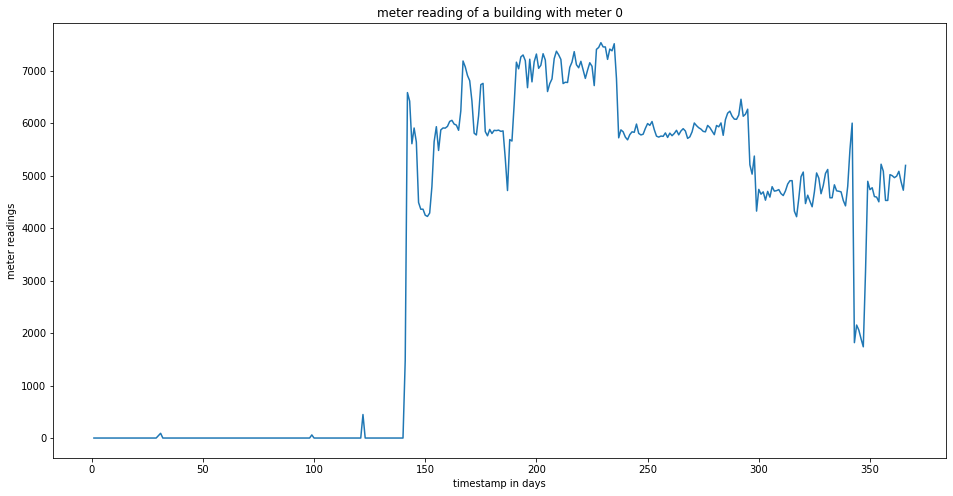

In [ ]:
id_building = 0 #mention building id
meter_type = 0 # mention meter type
q = whole_year_reading(id_building,meter_type)

Below function gives the mean meter reading of the entire buildings per day.

In [ ]:
def reading_one_meter(meter):

    df_meter = df_train.query(f'meter=={meter}') # gets the rows where meter value is equal to above variable value
    df_meter['day'] = pd.to_datetime(df_meter['timestamp']).dt.dayofyear # adding a new coulmn of days, converting timestamp into days
    meter_reading_per_day =df_meter.groupby(['day'])['meter_reading'].mean() # We are taking the avg meter reading per day (not the entire sum)
    plt.figure(figsize=(20,10))
    plt.plot(meter_reading_per_day)
    
    return df_meter

#### Meter readings per day

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


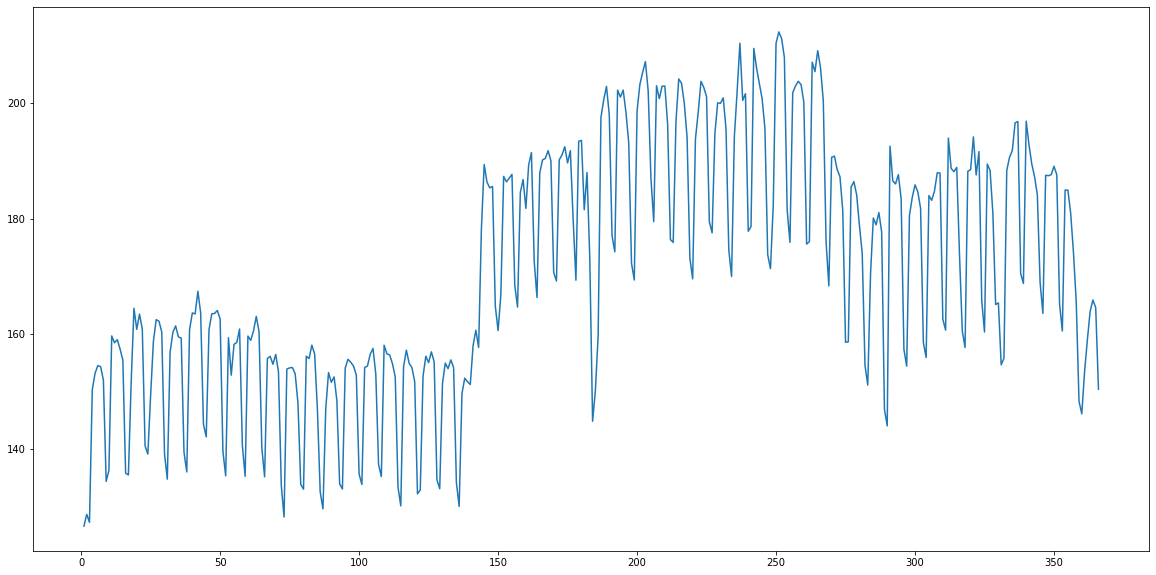

In [ ]:
meter_0 = reading_one_meter(0)

Meter 1 : chilled water

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


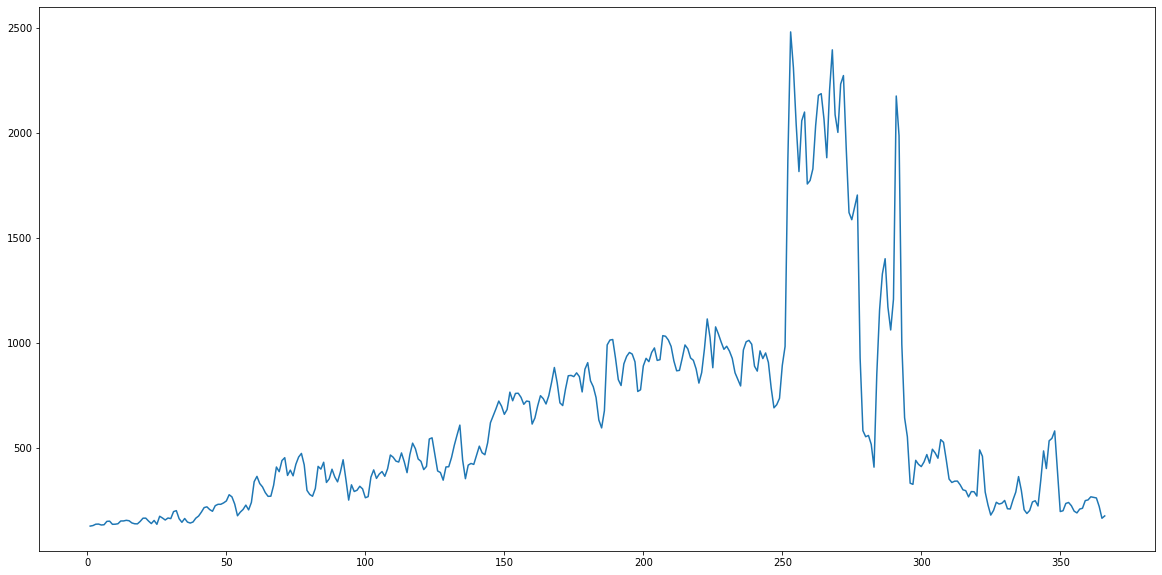

In [ ]:
meter_1 = reading_one_meter(1)

####Steam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


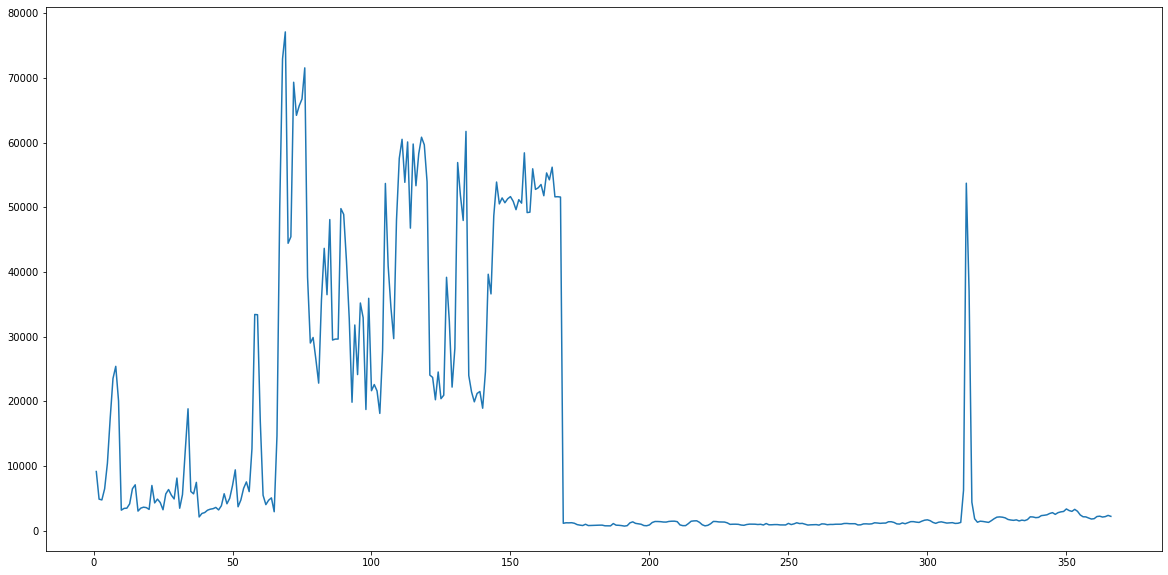

In [ ]:
meter_2 = reading_one_meter(2)

#### Meter 3 : Hot water

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


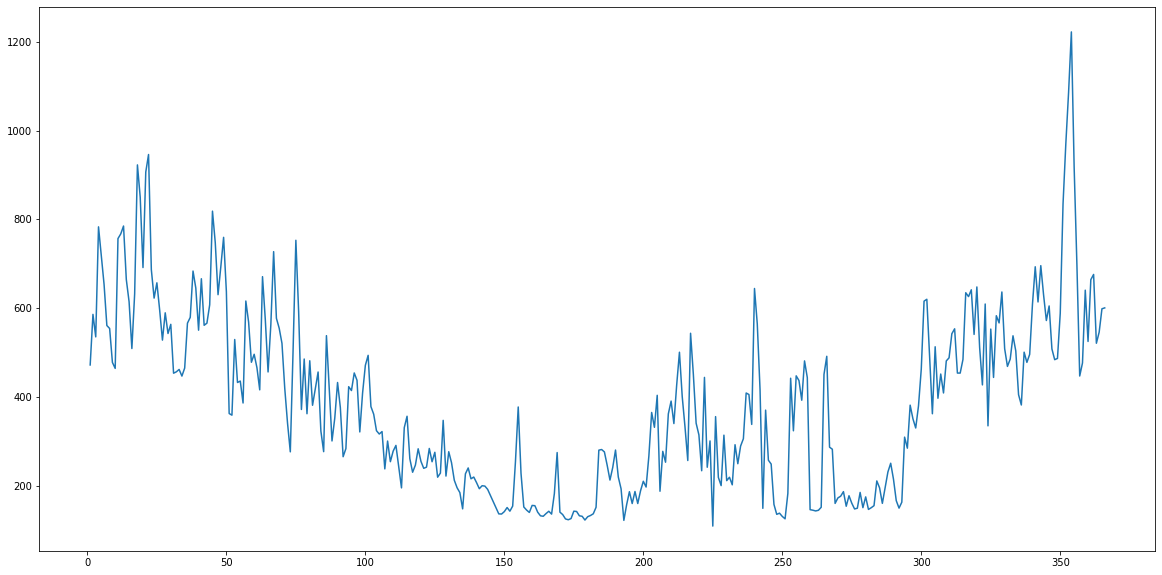

In [ ]:
meter_3 = reading_one_meter(3)

#### Distribution of meter reading in train data

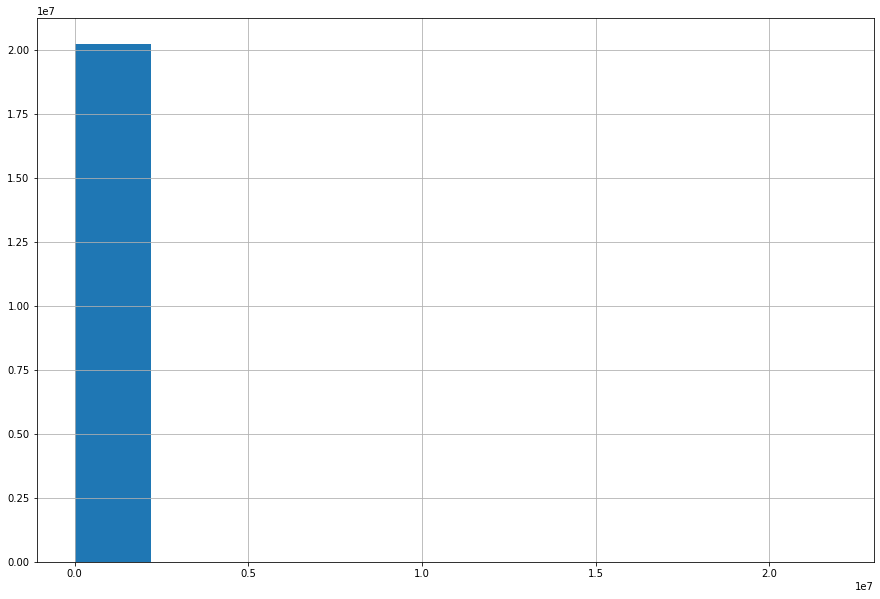

In [ ]:
df_train['meter_reading'].hist(figsize=(15,10)) # Since the large part of the distribution is close to zero, we have to use log to get a better understanding.

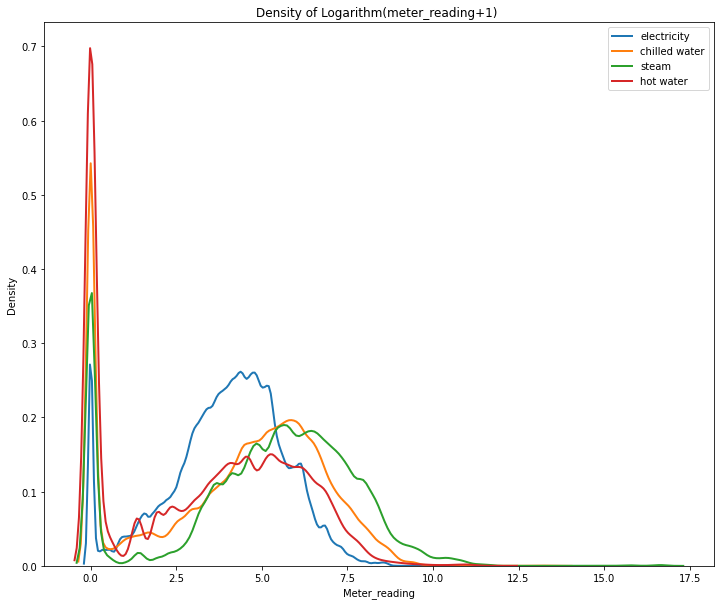

In [ ]:
# will take some time to run
plt.figure(figsize=(12,10))
# list of different meters
meters = sorted(df_train['meter'].unique().tolist())

for meter in meters:
  subset = df_train[df_train['meter']== meter]
  sns.kdeplot(np.log1p(subset['meter_reading']),linewidth = 2, label = meter)

  plt.ylabel('Density')
  plt.xlabel('Meter_reading')
  plt.legend(['electricity', 'chilled water', 'steam', 'hot water'])
  plt.title('Density of Logarithm(meter_reading+1) ', size =12)

#### Meter reading of all building over a year

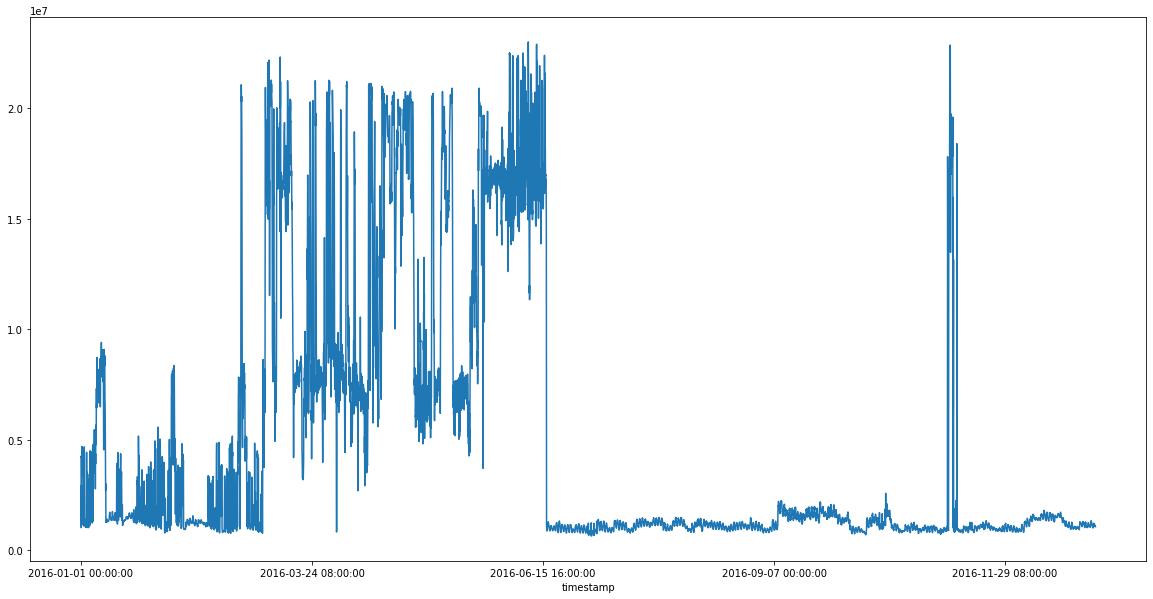

In [ ]:
building_meter = df_train.groupby(['timestamp'])['meter_reading'].sum()

fig, ax = plt.subplots(figsize=(20,10))

building_meter.plot(ax=ax, x_compat = True)
plt.show()

Electricity usage is high till june, but after june it dips but again increases during Nov for a short period of time.


In [ ]:
def distant_plot(feature):
  fig, ax = plt.subplots(figsize=(10,10))
  sns.distplot(df_weather_train[feature].dropna(), ax= ax).set_title(feature, fontsize=16)
  plt.xlabel(feature,fontsize=15)
  plt.legend(['train'])
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


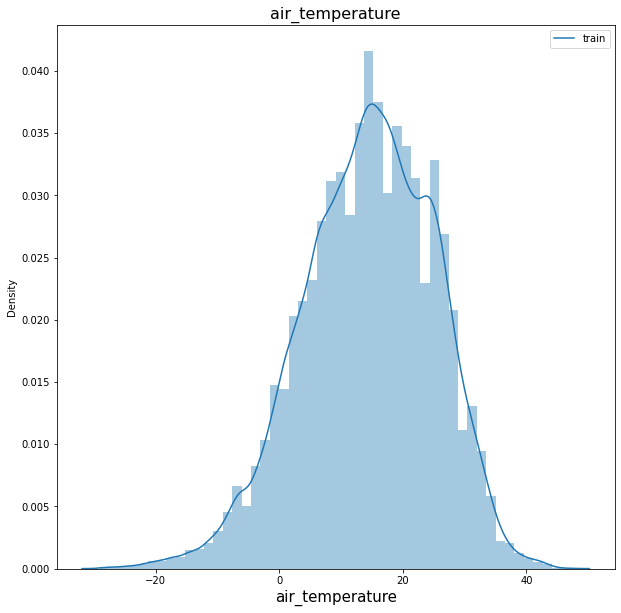

In [ ]:
distant_plot('air_temperature')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


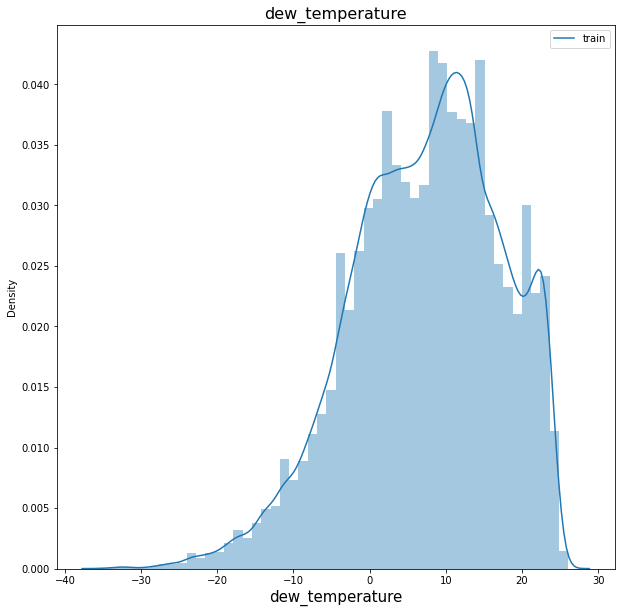

In [ ]:
distant_plot('dew_temperature')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


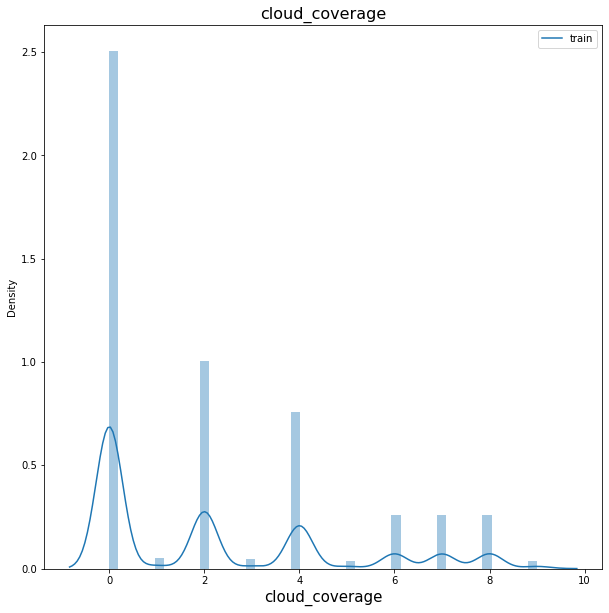

In [ ]:
distant_plot('cloud_coverage')

0 means clear sky and 9 means very cloudy. 

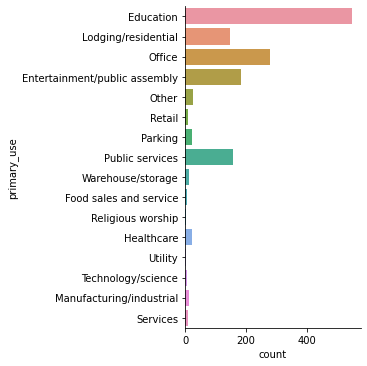

In [ ]:
sns.catplot(y='primary_use',data = df_building, kind='count')

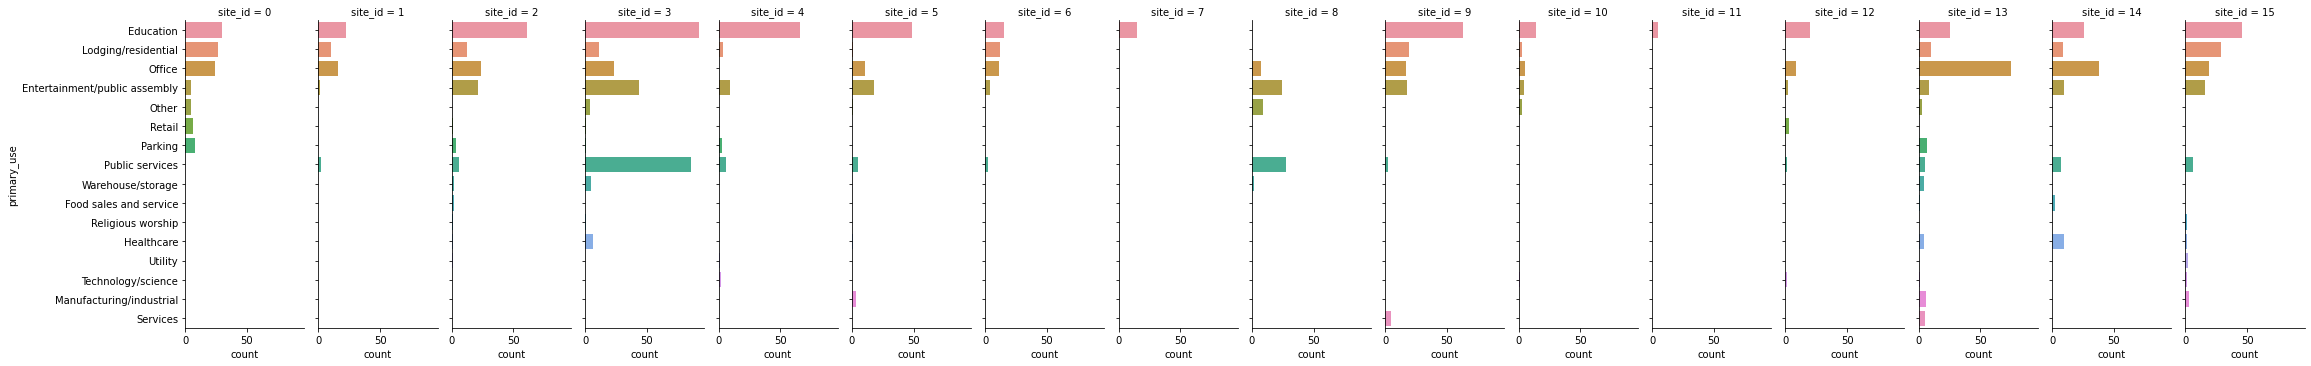

In [ ]:
sns.catplot(y='primary_use',data= df_building,col='site_id',kind ='count',aspect= .4 )

Distribution of floor area

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


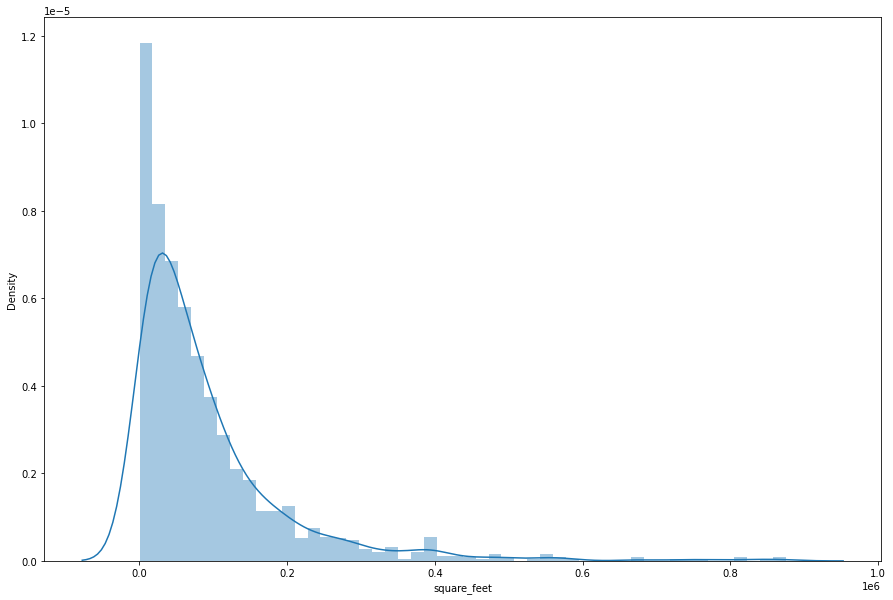

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(df_building['square_feet'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


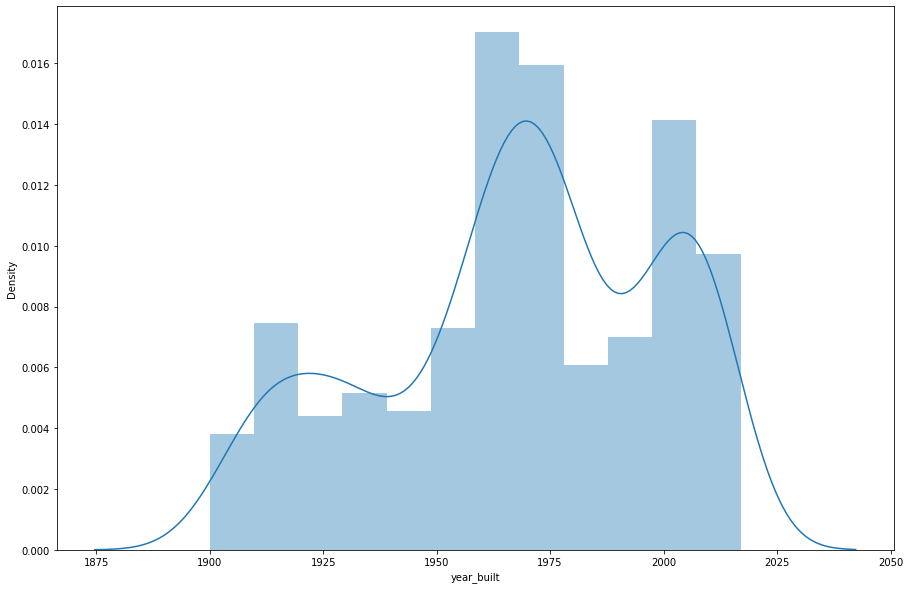

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(df_building['year_built'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


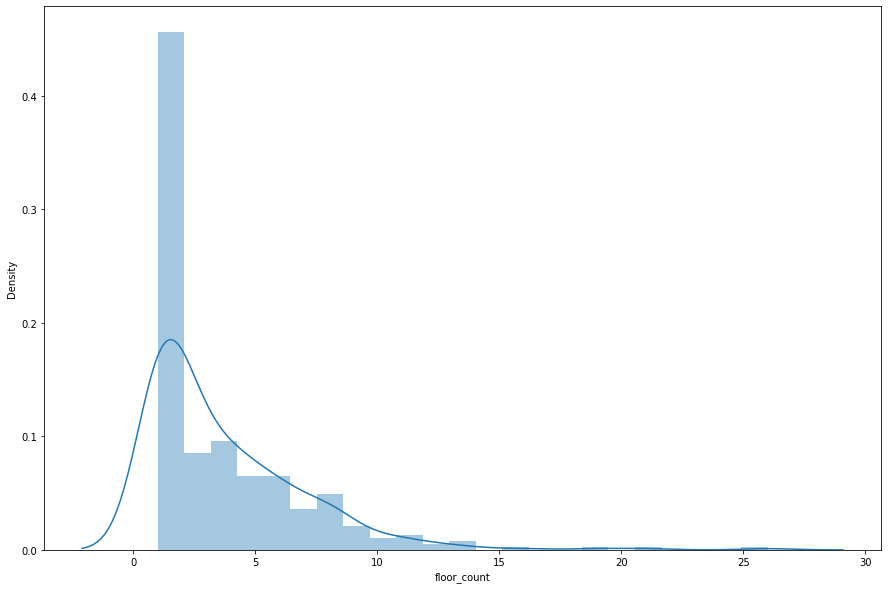

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(df_building['floor_count'])

## Merging Data

The merging seems like fun, what we really have to do is first merge the df- df_building into df_train, based on building_id, this would give each row in the df_train the extra details of each building. and then to this we merge the weather data of each building based on site id. This will give the final df,with data on building and weather.

In [ ]:
df_train_merge = df_train.merge(df_building, how='left',on='building_id').merge(df_weather_train,how='left',on=['site_id','timestamp'])
df_train_merge.describe()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,8088455.0,3506933.0,2.011944e+07,11390735.0,2.011596e+07,16467077.0,18984431.0,18767052.0,2.007242e+07
mean,7.992780e+02,6.624412e-01,1.988706e+03,7.992232e+00,1.077830e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.269133e+02,9.309921e-01,1.532159e+05,5.099060e+00,1.171424e+05,NaN,0.0,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,0.000000e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1900.0,1.0,-2.890625e+01,0.0,-3.500000e+01,-1.0,968.0,0.0,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01,3.000000e+00,3.252700e+04,1951.0,1.0,8.601562e+00,0.0,0.000000e+00,0.0,1011.5,70.0,2.099609e+00
50%,8.950000e+02,0.000000e+00,7.877500e+01,9.000000e+00,7.270900e+04,1969.0,3.0,1.670312e+01,0.0,8.898438e+00,0.0,1016.0,180.0,3.099609e+00
75%,1.179000e+03,1.000000e+00,2.679840e+02,1.300000e+01,1.391130e+05,1993.0,6.0,2.409375e+01,4.0,1.609375e+01,0.0,1020.5,280.0,4.601562e+00
max,1.448000e+03,3.000000e+00,2.190470e+07,1.500000e+01,8.750000e+05,2017.0,26.0,4.718750e+01,9.0,2.609375e+01,343.0,1046.0,360.0,1.900000e+01


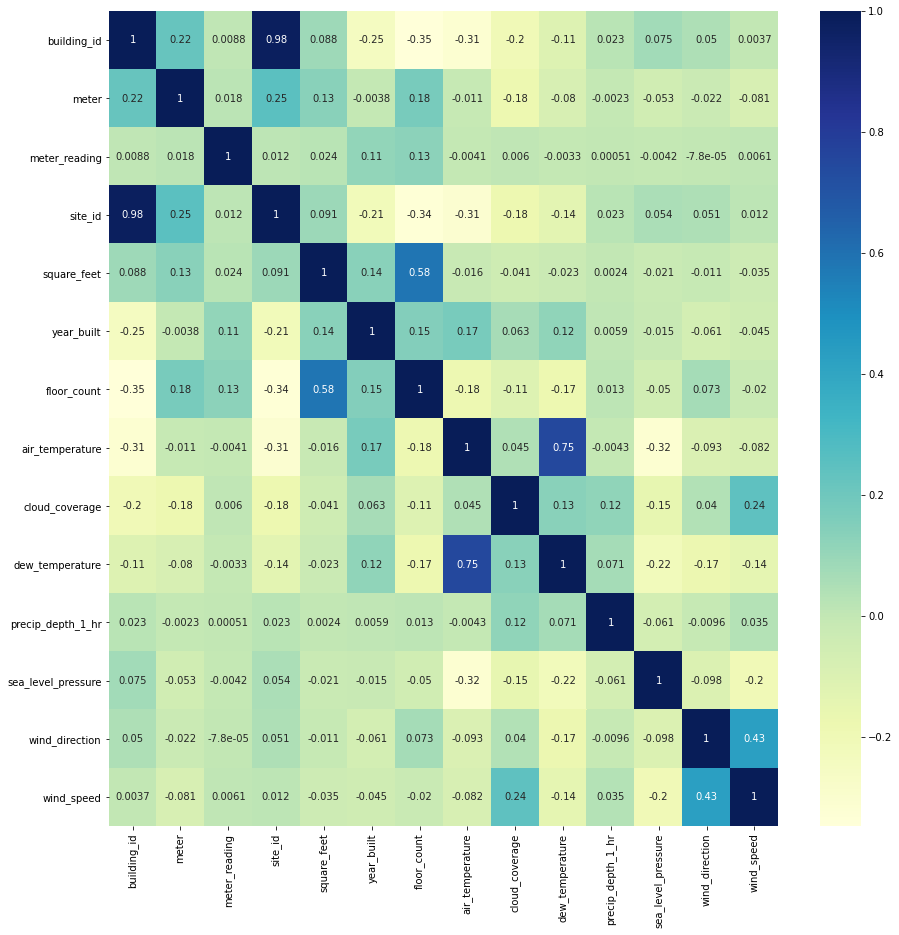

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df_train_merge.corr(),annot=True, cmap='YlGnBu')

In [ ]:
sns.catplot(y='meter_reading', x= 'site_id',data=df_train_merge,col='meter',kind='bar')

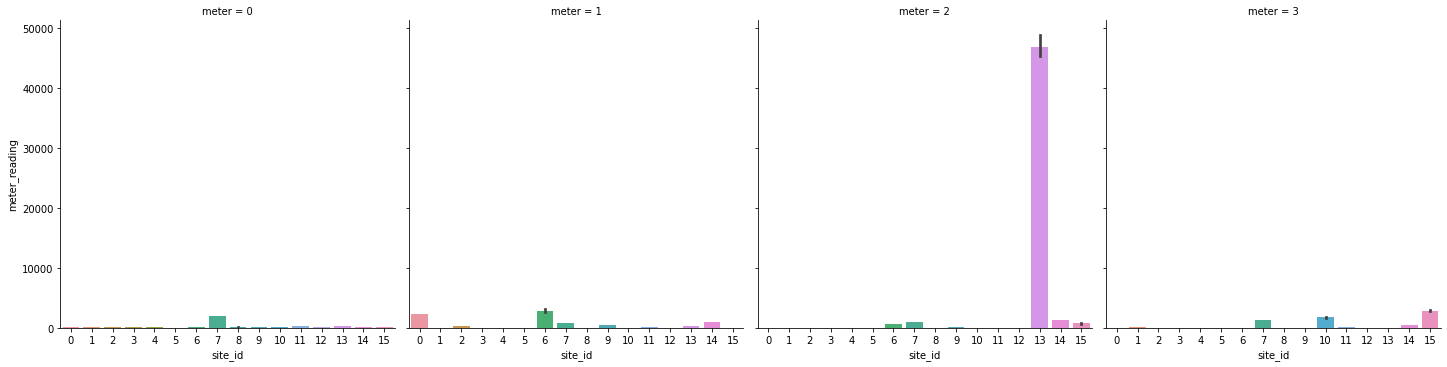

In [ ]:
sns.catplot(y='meter_reading', x= 'site_id',data=df_train_merge,col='meter',kind='bar')

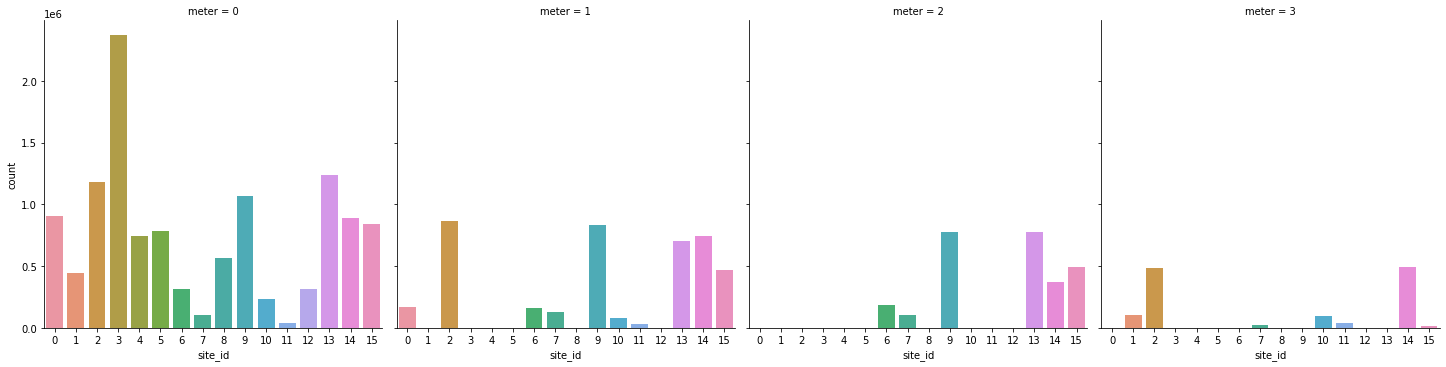

In [ ]:
sns.catplot( x= 'site_id',data=df_train_merge,col='meter',kind='count')

## Missing Data

In train data

In [ ]:
total = df_train.isnull().sum()
percentage = df_train.isnull().sum()/df_train.shape[0] *100
table = pd.concat([total, percentage],axis=1  ,keys=['Total', 'Missing_Percentage'])
table 


,Total,Missing_Percentage
building_id,0,0.0
meter,0,0.0
timestamp,0,0.0
meter_reading,0,0.0


Building Data

In [ ]:
total = df_building.isnull().sum().sort_values(ascending= False)
percentage = (df_building.isnull().sum()/df_building.shape[0] *100).sort_values(ascending= False)
table = pd.concat([total, percentage],axis=1  ,keys=['Total', 'Missing_Percentage'])
table 


,Total,Missing_Percentage
site_id,0,0.000000
building_id,0,0.000000
primary_use,0,0.000000
square_feet,0,0.000000
year_built,774,53.416149
floor_count,1094,75.500345


In [ ]:
# We can drop floor count from the df_building since it is highly corelated with sqaure_feet and also more than 75% nulls values

df_building_drop = df_building.drop(['floor_count','year_built'], axis =1)

In [ ]:
df_building_drop.head()


,site_id,building_id,primary_use,square_feet
0,0,0,Education,7432
1,0,1,Education,2720
2,0,2,Education,5376
3,0,3,Education,23685
4,0,4,Education,116607


Weather data Train

In [ ]:
total = df_weather_train.isnull().sum().sort_values(ascending= False)
percent = (df_weather_train.isnull().sum()/df_weather_train.shape[0]*100).sort_values(ascending= False)
table = pd.concat([total,percent],axis =1, keys=['Total','Percentage'])
table

,Total,Percentage
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
timestamp,0,0.000000
site_id,0,0.000000


We can remove the cloud_coverage and precip from the weather_df, but we can first build a model without the weather data

We need to group by or query each building and then sum up the meter_readings, we can also have for each meter as well but that is fine.

### Building Meter readings

In [ ]:
def electricity_consumption(building):
    building_reading = df_train.query(f'building_id=={0}')['meter_reading'].sum()

    return building_reading

In [ ]:
def each_building_consumption() : 
    'This function building energy consumption of all meters '
    p21=df_train.groupby(["building_id"])["meter_reading"].sum()
    k = 'consumption of each building '
    p21.astype('float')
    plt.figure(figsize=(16,8))
    plt.title(k)
    plt.xlabel('building id')
    #plt.xticks(rotation='vertical')
    plt.ylabel('meter_reading')
    #plt.xlim(700,1440)
    plt.plot(p21)
    return p21

#### Outliers

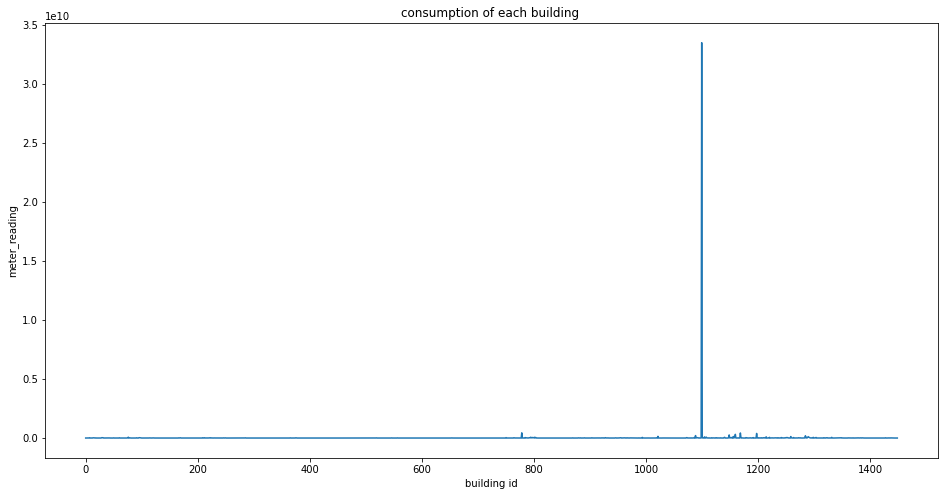

In [ ]:
k = each_building_consumption()

Building 1099 - Outlier


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


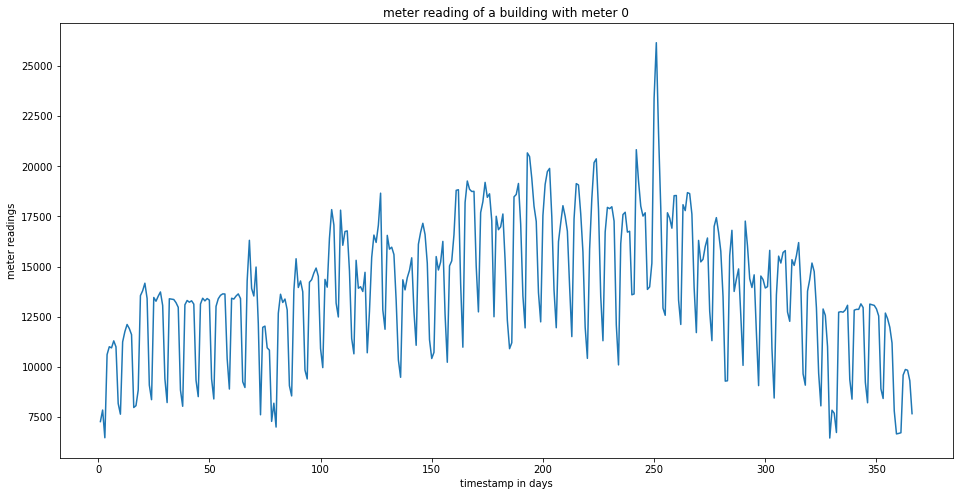

In [ ]:
building_id = 1099#mention building id
meter = 0# mention meter type
q = whole_year_reading(building_id, meter)

## Understanding Pipeline and Transforms


Using pipelines for transformations

#### Merging Data for Modeling

In [ ]:
df_train_merge = df_train.merge(df_building, how='left',on='building_id').merge(df_weather_train,how='left',on=['site_id','timestamp'])
df_train_merge['week'] = pd.to_datetime(df_train_merge['timestamp']).dt.day



In [ ]:
# df_train_merge_new = df_train_merge.drop(['floor_count','year_built','cloud_coverage','timestamp'],axis =1)

In [ ]:

# df_train_merge['day'] = pd.to_datetime(df_train_merge['timestamp']).dt.day

# df_train_merge['month'] = pd.to_datetime(df_train_merge['timestamp'].dt.day)


In [ ]:
feature_names =['building_id', 'meter', 'site_id', 'primary_use',
       'square_feet', 'air_temperature', 'dew_temperature',
       'sea_level_pressure', 'wind_speed', 'week']

targetname = ['meter_reading']

In [ ]:
from sklearn.impute import SimpleImputer


In [ ]:
categorical_features = ['primary_use']

numeric_features = ['square_feet','sea_level_pressure']

In [ ]:
# Pipeline is used when we have to carry out set of transforms and then there will be a final estimator(model), but it works even if you just want to apply transformations without estimator like below transform for contnous

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]) # i think we have used pipelie and steps here is because we have two transformation to be carried out
categorical_transformer = OrdinalEncoder() # since there is only one transform we do not need pipeline

# We are applying columntransformer, and we are passing the above transformers that we have passed in, this acts like a proper preprocessing stepsm we also pass in features that we need it to be applied on, the strings are just the names
# we would have to add remainder = 'passthrough', so that it wont perform transformation on other columns, for now the fit will only take place in the columns that we have given.
preprocessor = ColumnTransformer(transformers= [('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_features)]) 

# ct = ColumnTransformer(transformers=transformers, remainder="passthrough")

In [ ]:
# here something amazing is happening, pipeline requires two things transformers and model, 
# here we are passing a ColumnTransformer which itself is a transformer, which has more transformers, once the perform this
# transformation finally the model will act
clf = Pipeline(steps= [('preprocessor', preprocessor), ('classifier', LinearRegression())])

In [ ]:
data = df_train_merge_new[df_train_merge_new['meter']== 1].head(500)
X = data.drop(['meter_reading'],axis=1)
y = data['meter_reading']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)
# When we try to fit this what happens is the steps in pipeline start working first the preprocessor starts which consist of set of transforms to be applied 
# once that is applied to the columsn that we have specified in the transformers we finally fit. 
# The good thing about the model is even if we want to use this model in new data, we do not have to do tranformation on this new data
# when we call fit, it does all the transformation on the new data
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [ ]:

print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.139


#### cv_optimize function

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    print('cv_work')
    if score_func:
        print("SCORE FUNC", score_func)
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
        print('grid_search over')
    else:
        print('gridSearch start')
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
        print('grid_search over')
    print('fitting starts')    
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, 
                featurenames, targetname, mask=False, 
                score_func=None, n_folds=5, n_jobs=1):
    X=indf[featurenames]
    y=indf[targetname]
    if not mask:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, random_state= 7, train_size = 0.8 )
        print('train_test_split_done')
    # else: # mask is to be used
    #     print("using mask")
    #     Xtrain, Xtest, ytrain, ytest = X[reuse_split], X[~reuse_split], y[reuse_split], y[~reuse_split]
    if parameters:
        print('working on Cv_optimize next')
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
        print('cv_optimize_fun_done')
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict 0.5 ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, dict(Xtrain=Xtrain, ytrain=ytrain, Xtest=Xtest, ytest=ytest)

## Working with Missing Values

What should we do next? 
We were not able to do the fit was because we had lot of Nan values in the dataset we were trying to fit, we needed to do null handling and after that transformation. The thing is we can do null handling(imputation) and transformation together. 
We can first look at the data set, undertsand the missing values and decide what to do about it and then do it and then fit the model and see how it goes. 

In [ ]:
df_train_merge.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,week
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,1
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,1
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,1
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,1
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,1


In [ ]:
# Missing Values
total = df_train_merge.isnull().sum().sort_values(ascending= False)
percentage = (df_train_merge.isnull().sum()/df_train_merge.shape[0] *100).sort_values(ascending= False)
table = pd.concat([total, percentage],axis=1  ,keys=['Total', 'Missing_Percentage'])
table 


,Total,Missing_Percentage
floor_count,16709167,82.652772
year_built,12127645,59.990033
cloud_coverage,8825365,43.655131
precip_depth_1_hr,3749023,18.544739
wind_direction,1449048,7.167792
sea_level_pressure,1231669,6.092515
wind_speed,143676,0.710701
dew_temperature,100140,0.495348
air_temperature,96658,0.478124
meter_reading,0,0.000000


Looking at the above values we can decide to drop floor_count, year_built, and cloud coverage

In [ ]:
df_train_merge_new = df_train_merge.drop(['floor_count','year_built','cloud_coverage','timestamp'],axis =1)

In [ ]:
tbl_report(df_train_merge_new)

Table Shape (20216100, 13)


,dtype,nulls,uniques,num_uniques,value_counts
building_id,int16,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1449,HC
meter,int8,0,"[0, 3, 1, 2]",4,0:12060910\n1:4182440\n2:2708713\n3:1264037
meter_reading,float32,0,"[0.0, 53.2397, 43.0013, 52.4206, 23.3036, 0.37...",1688175,HC
site_id,int8,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",16,HC
primary_use,object,0,"[Education, Lodging/residential, Office, Enter...",16,HC
square_feet,int32,0,"[7432, 2720, 5376, 23685, 116607, 8000, 27926,...",1397,HC
air_temperature,float16,96658,"[25.0, 3.8, 15.6, 10.0, nan, -1.8, 1.9, -8.3, ...",620,HC
dew_temperature,float16,100140,"[20.0, 2.4, -5.6, 2.2, nan, -3.2, -1.2, -12.2,...",523,HC
precip_depth_1_hr,float16,3749023,"[nan, -1.0, 0.0, 5.0, 2.0, 3.0, 8.0, 13.0, 10....",129,HC
sea_level_pressure,float16,1231669,"[1019.5, 1021.0, 1015.5, nan, 1016.0, 1023.5, ...",134,HC


Now we have to decide on how to deal with nan values in other columns (other than the ones we dropped), also based on what we have to select the columns to do transformations

In [ ]:
df_train_merge_new.describe()

,building_id,meter,meter_reading,site_id,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,week
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.011944e+07,2.011596e+07,16467077.0,18984431.0,18767052.0,2.007242e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,1.988706e+03,7.992232e+00,1.077830e+05,NaN,NaN,NaN,NaN,NaN,NaN,1.576123e+01
std,4.269133e+02,9.309921e-01,1.532159e+05,5.099060e+00,1.171424e+05,0.000000e+00,0.000000e+00,NaN,NaN,NaN,0.000000e+00,8.820535e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,-2.890625e+01,-3.500000e+01,-1.0,968.0,0.0,0.000000e+00,1.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01,3.000000e+00,3.252700e+04,8.601562e+00,0.000000e+00,0.0,1011.5,70.0,2.099609e+00,8.000000e+00
50%,8.950000e+02,0.000000e+00,7.877500e+01,9.000000e+00,7.270900e+04,1.670312e+01,8.898438e+00,0.0,1016.0,180.0,3.099609e+00,1.600000e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02,1.300000e+01,1.391130e+05,2.409375e+01,1.609375e+01,0.0,1020.5,280.0,4.601562e+00,2.300000e+01
max,1.448000e+03,3.000000e+00,2.190470e+07,1.500000e+01,8.750000e+05,4.718750e+01,2.609375e+01,343.0,1046.0,360.0,1.900000e+01,3.100000e+01


We can take a subset of the entire data. We can work on the data from meter-1

#### Working with Iterative Imputer (predicts values for Nan values)


In [ ]:

df_train_meter_1 = df_train_merge_new[df_train_merge_new['meter']==1]

In [ ]:
# we would have to convert primary_use to ordinal or one_hot before we do the IterativImputer
encoder = OrdinalEncoder()
encoder.fit_transform(df_train_meter_1['primary_use'].values.reshape(-1, 1) )
# encoder.transform()


In [ ]:
df_train_meter_1['primary_use'] = encoder.transform(df_train_meter_1['primary_use'].values.reshape(-1, 1) )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_train_meter_1.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,week
172,161,1,0.000000,2,0.0,11329,15.601562,-5.601562,NaN,1015.5,270.0,3.599609,1
174,162,1,0.000000,2,0.0,98829,15.601562,-5.601562,NaN,1015.5,270.0,3.599609,1
176,163,1,4.571900,2,0.0,72102,15.601562,-5.601562,NaN,1015.5,270.0,3.599609,1
181,166,1,209.886002,2,4.0,553210,15.601562,-5.601562,NaN,1015.5,270.0,3.599609,1
184,167,1,0.000000,2,4.0,86323,15.601562,-5.601562,NaN,1015.5,270.0,3.599609,1


In [ ]:
# using Iterative imputer
# https://scikit-learn.org/stable/modules/impute.html
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


In [ ]:
imp = IterativeImputer(max_iter=10,random_state=7)

In [ ]:
df_train_meter_1.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,week
172,161,1,0.000000,2,Education,11329,15.601562,-5.601562,NaN,1015.5,270.0,3.599609,1
174,162,1,0.000000,2,Education,98829,15.601562,-5.601562,NaN,1015.5,270.0,3.599609,1
176,163,1,4.571900,2,Education,72102,15.601562,-5.601562,NaN,1015.5,270.0,3.599609,1
181,166,1,209.886002,2,Lodging/residential,553210,15.601562,-5.601562,NaN,1015.5,270.0,3.599609,1
184,167,1,0.000000,2,Lodging/residential,86323,15.601562,-5.601562,NaN,1015.5,270.0,3.599609,1


In [ ]:
imp.fit(df_train_meter_1)

IterativeImputer(add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=None, random_state=7,
                 sample_posterior=False, skip_complete=False, tol=0.001,
                 verbose=0)

In [ ]:
X = imp.transform(df_train_meter_1)

In [ ]:
X

array([[1.61000000e+02, 1.00000000e+00, 0.00000000e+00, ...,
        2.70000000e+02, 3.59960938e+00, 1.00000000e+00],
       [1.62000000e+02, 1.00000000e+00, 0.00000000e+00, ...,
        2.70000000e+02, 3.59960938e+00, 1.00000000e+00],
       [1.63000000e+02, 1.00000000e+00, 4.57189989e+00, ...,
        2.70000000e+02, 3.59960938e+00, 1.00000000e+00],
       ...,
       [1.41100000e+03, 1.00000000e+00, 0.00000000e+00, ...,
        1.80000000e+02, 8.79687500e+00, 3.10000000e+01],
       [1.41200000e+03, 1.00000000e+00, 0.00000000e+00, ...,
        1.80000000e+02, 8.79687500e+00, 3.10000000e+01],
       [1.41300000e+03, 1.00000000e+00, 2.53139997e+00, ...,
        1.80000000e+02, 8.79687500e+00, 3.10000000e+01]])

In [ ]:

df = pd.DataFrame(np.vstack(X),columns= df_train_meter_1.columns)

In [ ]:
df.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,week
0,161.0,1.0,0.000000,2.0,0.0,11329.0,15.601562,-5.601562,-0.331293,1015.5,270.0,3.599609,1.0
1,162.0,1.0,0.000000,2.0,0.0,98829.0,15.601562,-5.601562,-0.327833,1015.5,270.0,3.599609,1.0
2,163.0,1.0,4.571900,2.0,0.0,72102.0,15.601562,-5.601562,-0.329155,1015.5,270.0,3.599609,1.0
3,166.0,1.0,209.886002,2.0,4.0,553210.0,15.601562,-5.601562,-0.347132,1015.5,270.0,3.599609,1.0
4,167.0,1.0,0.000000,2.0,4.0,86323.0,15.601562,-5.601562,-0.366560,1015.5,270.0,3.599609,1.0


In [ ]:
tbl_report(df)

Table Shape (4182440, 13)


,dtype,nulls,uniques,num_uniques,value_counts
building_id,float64,0,"[161.0, 162.0, 163.0, 166.0, 167.0, 168.0, 169...",498,HC
meter,float64,0,[1.0],1,1.0:4182440
meter_reading,float64,0,"[0.0, 4.571899890899658, 209.88600158691406, 5...",868096,HC
site_id,float64,0,"[2.0, 6.0, 7.0, 9.0, 10.0, 11.0, 13.0, 14.0, 1...",10,HC
primary_use,float64,0,"[0.0, 4.0, 11.0, 6.0, 1.0, 2.0, 9.0, 3.0, 13.0...",14,HC
square_feet,float64,0,"[11329.0, 98829.0, 72102.0, 553210.0, 86323.0,...",493,HC
air_temperature,float64,0,"[15.6015625, 17.768671219505336, 17.6542330478...",21128,HC
dew_temperature,float64,0,"[-5.6015625, 8.813394009397491, 8.887357913237...",21871,HC
precip_depth_1_hr,float64,0,"[-0.33129301578418335, -0.3278333364774255, -0...",538518,HC
sea_level_pressure,float64,0,"[1015.5, 1016.7274563445095, 1016.808049262303...",102034,HC


#### Doing Scaling now

In [ ]:
numeric_features = ['square_feet','air_temperature','dew_temperature','sea_level_pressure','wind_direction']

In [ ]:
df['meter_reading'] = np.log(df['meter_reading'])

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
df['meter_reading']

0              -inf
1              -inf
2          1.519929
3          5.346565
4              -inf
             ...   
4182435    2.934495
4182436    2.815409
4182437        -inf
4182438        -inf
4182439    0.928772
Name: meter_reading, Length: 4182440, dtype: float64

In [ ]:
df = df.replace([np.inf, -np.inf], np.nan)

In [ ]:
df = df.fillna(0)

In [ ]:
df.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,week
0,161.0,1.0,0.000000,2.0,0.0,11329.0,15.601562,-5.601562,-0.331293,1015.5,270.0,3.599609,1.0
1,162.0,1.0,0.000000,2.0,0.0,98829.0,15.601562,-5.601562,-0.327833,1015.5,270.0,3.599609,1.0
2,163.0,1.0,1.519929,2.0,0.0,72102.0,15.601562,-5.601562,-0.329155,1015.5,270.0,3.599609,1.0
3,166.0,1.0,5.346565,2.0,4.0,553210.0,15.601562,-5.601562,-0.347132,1015.5,270.0,3.599609,1.0
4,167.0,1.0,0.000000,2.0,4.0,86323.0,15.601562,-5.601562,-0.366560,1015.5,270.0,3.599609,1.0


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
numeric_transformer = StandardScaler() # I dont have to use pipeline because i am doing only one transform

preprocessor = ColumnTransformer(transformers= [('numeric', numeric_transformer, numeric_features)],remainder = 'passthrough')

clf = Pipeline(steps=[('preprocessor',preprocessor), ('classifier', RandomForestRegressor())])


In [ ]:

X = df.drop(['meter_reading'],axis=1)
y = df['meter_reading']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=0)

In [ ]:
X_train['meter'].nunique()

1

In [ ]:
clf.fit(X_train, y_train)

In [ ]:

print("model score: %.3f" % clf.score(X_test, y_test))